# 7-11. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된
Naver sentiment movie corpus (https://github.com/e9t/nsmc) 입니다.

## 1) 데이터 준비와 확인

In [22]:
# 필요한 라이브러리 import
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [23]:
train_data.head(6)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0


In [24]:
test_data.head(6)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
5,7898805,"음악이 주가 된, 최고의 음악영화",1


## 2) 데이터로더 구성
---
실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다.

그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다.

이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. 

data_loader 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [25]:
from konlpy.tag import Mecab

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()   # concatenate 는 합치는 것, 리스트 안에 리스트 있는 걸 플랫하게, ex. [[1,2][3,4]] -> [1,2,3,4]로
    counter = Counter(words)
    counter = counter.most_common(10000-4)   # 10000-4 를 하는 이유? 앞에 빈칸 4개를 제외하고 9996개를 뽑아내는 거
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [27]:
# train data 의 길이를 살펴보고, word_to_index의 길이와 자료형을 확인해봅니다.
print(len(X_train)) 
print(len(y_train)) 

146182
146182


In [28]:
# test data 의 길이
print(len(X_test))
print(len(y_test))

49157
49157


In [29]:
print('word_to_index : ',len(word_to_index), type(word_to_index))

word_to_index :  9997 <class 'dict'>


- word_to_index에는 어떤 내용이 들어있는지 확인한다.
- word_to_index는 word:index 형태로 묶인 데이터들의 집합이다.
- 파이썬 프로그래밍의 index는 0부터 시작이다.
- 확인해 보면, 앞쪽에 있어야 할 PAD, BOS, UNK가 나타나지 않았음을 알 수 있다. 이들을 각각 index 0, 1, 2로 대응시켜 딕셔너리에 포함시킨다.

In [10]:
word_to_index

{'': 3,
 '.': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '하': 8,
 '을': 9,
 '보': 10,
 '..': 11,
 '게': 12,
 ',': 13,
 '!': 14,
 '지': 15,
 '있': 16,
 '없': 17,
 '?': 18,
 '좋': 19,
 '나': 20,
 '었': 21,
 '만': 22,
 '는데': 23,
 '너무': 24,
 '봤': 25,
 '적': 26,
 '안': 27,
 '정말': 28,
 '로': 29,
 '음': 30,
 '것': 31,
 '아': 32,
 '네요': 33,
 '재밌': 34,
 '어': 35,
 '같': 36,
 '점': 37,
 '지만': 38,
 '진짜': 39,
 '했': 40,
 '에서': 41,
 '기': 42,
 '네': 43,
 '않': 44,
 '거': 45,
 '았': 46,
 '수': 47,
 '되': 48,
 '면': 49,
 'ㅋㅋ': 50,
 '말': 51,
 '연기': 52,
 '인': 53,
 '주': 54,
 '내': 55,
 '최고': 56,
 '~': 57,
 '평점': 58,
 '이런': 59,
 '던': 60,
 '어요': 61,
 '할': 62,
 '왜': 63,
 '겠': 64,
 '1': 65,
 '스토리': 66,
 '해': 67,
 '습니다': 68,
 'ㅋㅋㅋ': 69,
 '...': 70,
 '드라마': 71,
 '생각': 72,
 '아니': 73,
 '더': 74,
 '그': 75,
 '싶': 76,
 '사람': 77,
 '듯': 78,
 '때': 79,
 '감동': 80,
 '함': 81,
 '배우': 82,
 '본': 83,
 '까지': 84,
 '뭐': 85,
 '알': 86,
 '만들': 87,
 '내용': 88,
 '볼': 89,
 '감독': 90,
 '보다': 91,
 '라': 92,
 '그냥': 93,
 '재미': 94,
 '시간': 95,
 '지루': 96,
 '중': 97,
 '재미있': 98,
 '년': 

In [30]:
word_to_index["<PAD>"] = 0  # 패딩
word_to_index["<BOS>"] = 1  # 모든 문장의 시작
word_to_index["<UNK>"] = 2  # Unknown을 의미

In [31]:
# index : 단어(키 : 값) 형태의 딕셔너리 생셩
index_to_word = {index:word for word, index in word_to_index.items()}

In [32]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [33]:
print("X_train len: ", len(X_train))
print("X_test len: ", len(X_test))

X_train len:  146182
X_test len:  49157


In [34]:
# index 첫 번째 값 Encoded, Decoded, Label 값 확인
print("Encoded Sentence: ", X_train[0])
print("Decoded Sentence: ", get_decoded_sentence(X_train[0], index_to_word))
print("Label(0, 1): ", y_train[0])

Encoded Sentence:  [32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
Decoded Sentence:  더 빙 . . 진짜 짜증 나 네요 목소리
Label(0, 1):  0


In [36]:
# index 10 번째 값 Encoded, Decoded, Label 값 확인
print("Encoded Sentence: ", X_train[9])
print("Decoded Sentence: ", get_decoded_sentence(X_train[15], index_to_word))
print("Label(0, 1): ", y_train[15])

Encoded Sentence:  [63, 656, 58, 240, 760, 18, 574, 89, 3, 4, 4, 1482, 637, 736, 81, 22, 24, 3, 16, 20, 18]
Decoded Sentence:  냥 매번 긴장 되 고 재 밋 음 ㅠㅠ
Label(0, 1):  1


## 3) 모델구성을 위한 데이터 분석 및 가공
---
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

### 전체 데이터셋의 분포 확인

In [14]:
# 테스트 데이터
total_data_text = list(X_train) + list(X_test)

# 텍스트 데이터 문장 길이의 리스트 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균값, 최대값, 표준편차 각각 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}% 정도가 maxlen 설정값 이내에 포함되어 있네요! '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575% 정도가 maxlen 설정값 이내에 포함되어 있네요! 


리뷰의 최대 길이 : 116
리뷰의 평균 길이 : 15.98170773419436


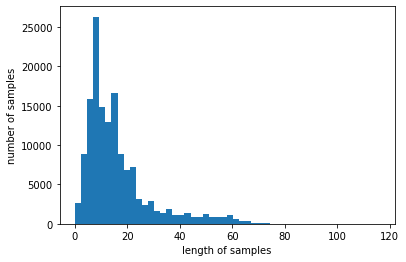

In [21]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train)) / len(X_train))

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
# padding을 통해 문장의 길이를 맞춘다.

x_train = pad_sequences(X_train,
                        value=word_to_index["<PAD>"],
                        padding='post', # 혹은 'pre'
                        maxlen=maxlen)

x_test = pad_sequences(X_test,
                       value=word_to_index["<PAD>"],
                       padding='post', # 혹은 'pre'
                       maxlen=maxlen)

print(x_train.shape)
print(x_test.shape)

(146182, 41)
(49157, 41)


- RNN은 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치게 된다. 그러므로 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율적이다. 따라서 'pre'가 훨씬 유리하며, 10% 이상의 테스트 성능 차이를 보이게 된다.

- 문장의 길이를 padding 을 이용하여 맞춤

In [39]:
# 훈련 데이터 앞쪽 10000개 까지 validation set으로 사용
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지는 모두 훈련 데이터로 사용
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)

(136182, 41)
(136182,)
(10000, 41)
(10000,)


- train set을 분리하여 일부를 validation set으로 사용
- 총 145791개의 train set 중, 10000개를 validation set으로 분리

## 4) 모델구성 및 validation set 구성
---
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [17]:
# 우선, 단어 사전의 크기를 지정해주고 한 단어를 표현하는 임베딩 벡터의 차원의 개수를 설정해준다.

# vocab_size = 10000  # 단어 사전의 크기를 지정
# word_vector_dim = 4   # 한 단어를 표현하는 임베딩 벡터의 차원의 개수

# 이제 각 모델을 구성하고 학습시킨 다음 평가를 실시한다.
# 평가 후에는 각 모델의 Accuracy, Loss 그래프를 시각화하여 나타낸다.

### 4-1. D Conv

In [40]:
# 1-D CNN 모델 구성

vocab_size = 10000 # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [41]:
# 1-D CNN 모델 학습

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 10  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

NameError: name 'X_val' is not defined

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], marker='.', c='red', label='Train Loss')
plt.plot(history.history['val_loss'], marker='.', c='blue', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g--', label='Train accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.show()

In [ ]:
# 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

## 5) 모델 훈련 개시
---

## 6) Loss, Accuracy 그래프 시각화
---

## 7) 학습된 Embedding 레이어 분석
---

## 8) 한국어 Word2Vec 임베딩 활용하여 성능개선
---

https://github.com/Kyubyong/wordvectors

프로젝트 평가문항
---

1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.
- 3가지 이상의 모델이 성공적으로 시도됨

2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.
- gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함

3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.
- 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함